In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
import xarray as xr
from glob import glob
import sys, os
import cartopy
cartopy.config['pre_existing_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['repo_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
pr1=ccrs.PlateCarree()

In [ ]:
dout=xr.open_zarr('/home1/datawork/kbalem/iwiv0mc5.zarr')
dout.load()

In [3]:
dout.isel(trajectory=0)

<xarray.Dataset> Size: 1kB
Dimensions:       (obs: 21)
Coordinates:
  * obs           (obs) int32 84B 0 1 2 3 4 5 6 7 8 ... 13 14 15 16 17 18 19 20
    trajectory    int64 8B 20
Data variables:
    cycle_age     (obs) float32 84B 300.0 2.1e+03 3.9e+03 ... 3.45e+04 3.63e+04
    cycle_number  (obs) float64 168B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    cycle_phase   (obs) float64 168B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    in_water      (obs) float32 84B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    lat           (obs) float64 168B 38.99 38.99 38.99 ... 38.99 38.99 38.99
    lon           (obs) float64 168B -12.77 -12.77 -12.77 ... -12.77 -12.77
    time          (obs) datetime64[ns] 168B 2008-04-01T12:00:00 ... 2008-04-0...
    z             (obs) float64 168B -2.5 -2.5 -2.5 -2.5 ... -2.5 -2.5 -2.5 -2.5
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ArgoParticleArgoFloatKernelAdvectionRK4KeepInWate...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [3]:
mask = xr.open_dataset('mask_glorys.nc')
mask = mask.rename({'__xarray_dataarray_variable__':'depth'})

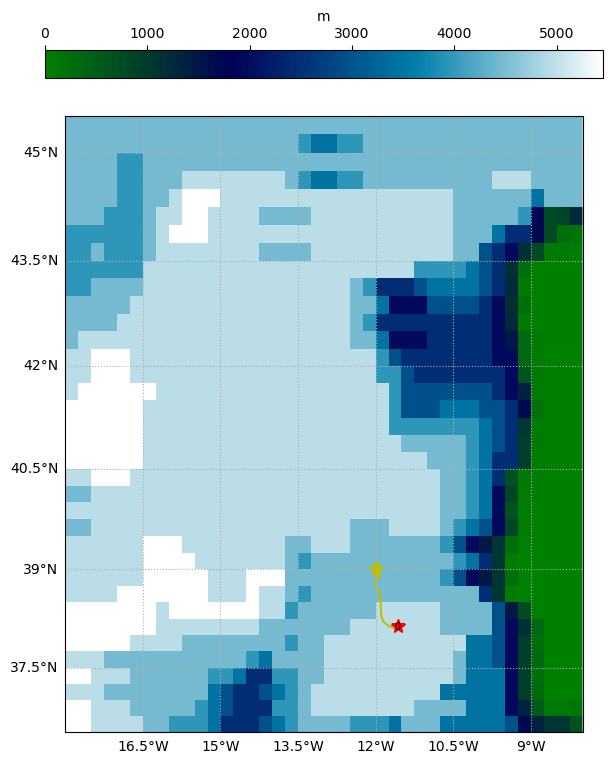

In [4]:
extent = [-18,-8,36.5,45.5]

fig=plt.figure(figsize=(12,10))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()

ax1 = fig.add_subplot(projection=pr2)
a=ax1.pcolormesh(mask.longitude,mask.latitude,mask['depth'],shading='auto',transform=pr1,cmap=plt.get_cmap('ocean'),vmin=0)
#ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'y*',markersize=10,transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'y',transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',markersize=10,transform=pr1)
    ax1.text(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),str(t),transform=pr1,ha='center',va='center',size='x-small')
plt.colorbar(a,location='top',shrink=0.6,label='m')
ax1.set_extent(extent)

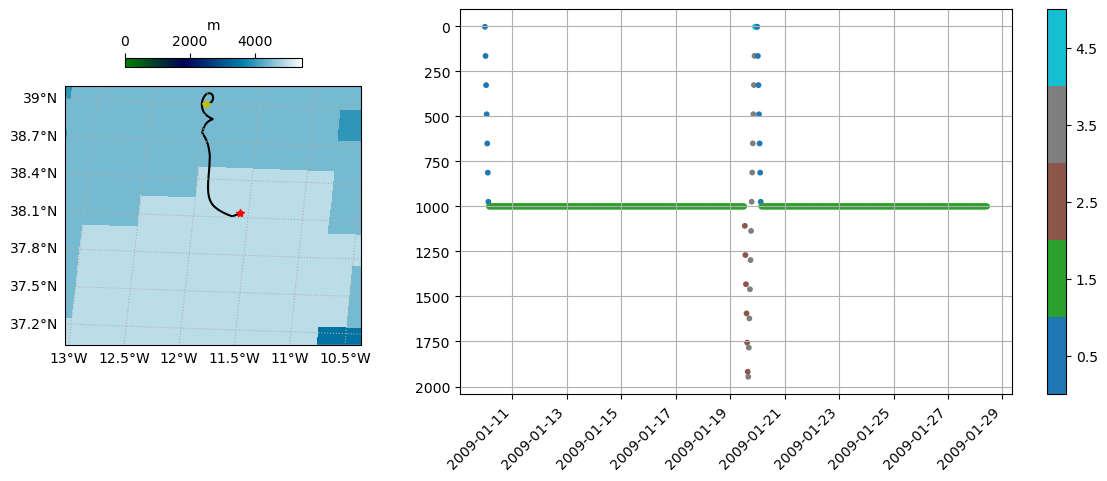

In [5]:
tr=0

fig=plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1,2,width_ratios=[.6,1.4])
pr1=ccrs.PlateCarree()
pr2=ccrs.LambertAzimuthalEqualArea()
ax1 = fig.add_subplot(gs[0], projection=pr2)
a=ax1.pcolormesh(mask.longitude,mask.latitude,mask['depth'],shading='auto',transform=pr1,cmap=plt.get_cmap('ocean'),vmin=0)
#ax1.contour(mask['depth_rho'].lon_rho,mask['depth_rho'].lat_rho,mask['depth_rho'],levels=2000,transform=pr1,colors='y')
#ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False

ax1.plot(dout['lon'].isel(trajectory=tr,obs=0),dout['lat'].isel(trajectory=tr,obs=0),'y*',transform=pr1,zorder=10)
ax1.plot(dout['lon'].isel(trajectory=tr),dout['lat'].isel(trajectory=tr),'k',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr,obs=-1),dout['lat'].isel(trajectory=tr,obs=-1),'r*',transform=pr1,zorder=10)
extent=[dout['lon'].isel(trajectory=tr).min().values -2,
        dout['lon'].isel(trajectory=tr).max().values +2,
        dout['lat'].isel(trajectory=tr).min().values -2,
        dout['lat'].isel(trajectory=tr).max().values +2]
ax1.set_extent([dout['lon'].isel(trajectory=tr).min()-1,
               dout['lon'].isel(trajectory=tr).max()+1,
               dout['lat'].isel(trajectory=tr).min()-1,
               dout['lat'].isel(trajectory=tr).min()+1])
plt.colorbar(a,location='top',shrink=0.6,label='m')

ax = fig.add_subplot(gs[1])
a=ax.scatter(dout['time'].isel(trajectory=tr),dout['z'].isel(trajectory=tr),s=10,c=dout['cycle_phase'].isel(trajectory=tr),cmap=plt.get_cmap('tab10',5),vmin=0,vmax=5)
ax.invert_yaxis()
_=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(':')
#ax.set_xlim([np.datetime64('2008-05-01'),np.datetime64('2008-05-20')])
plt.colorbar(a,ticks=[0.5,1.5,2.5,3.5,4.5])

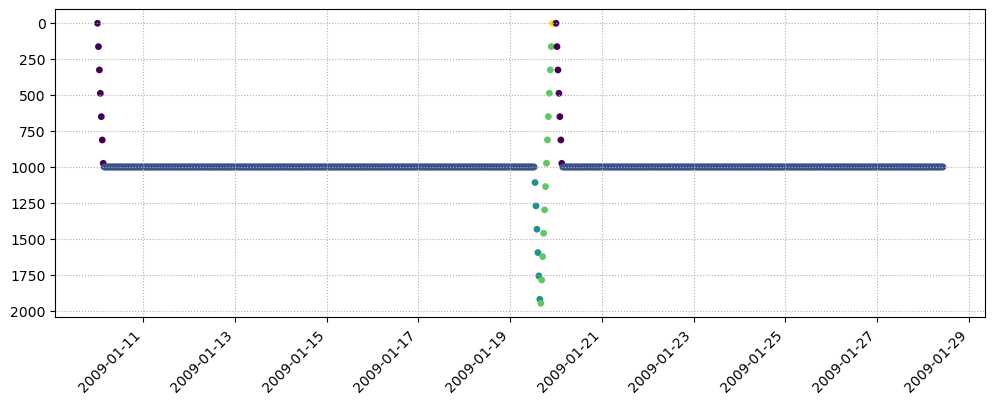

In [6]:
ddt = dout.isel(trajectory=tr)
f,ax=plt.subplots(figsize=(12,4))
ax.scatter(ddt['time'],ddt['z'],s=15,c=ddt['cycle_phase'])
#ax.set_xlim([np.datetime64('2008-04-20'),np.datetime64('2008-05-15')])
#ax.set_ylim([1100,500])
_=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.invert_yaxis()
ax.grid(linestyle=':')